Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [1]:
import random
import numpy as np
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from datasets import UCIHAR
import matplotlib.pyplot as plt
from utils import imputation_rmse, mean_impute, classify
from baringhaus import preprocess_baringhaus, compute_stat_Baringhaus
from models import TSImputer, GRUPlusFC
from sklearn.metrics import f1_score


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

/home/serrabii/travail/ia/ml-env/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [2]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.1

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training/testing
batch_size = 128

# Number of training epochs for imputation model
num_epochs = 50

# Number of training epochs for the classifier
clf_epochs = 100

# Learning rate for optimizers
lr = 0.005

# Generator MSELoss multiplier
alpha = 100

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



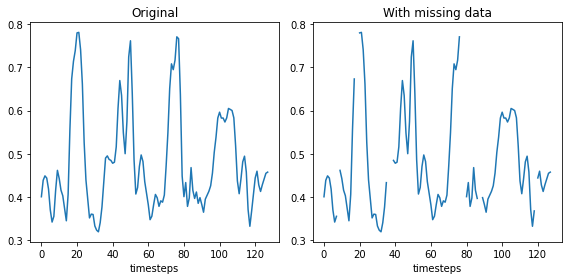

In [3]:
# Create the datasets
ucihar_observed = UCIHAR(root_dir=root, download=True)
ucihar_miss = UCIHAR(root_dir=root, miss_rate=miss_rate)
ucihar_test = UCIHAR(root_dir=root, train=False)

# Create the dataloaders
dataloader = DataLoader(ucihar_observed, batch_size=batch_size, num_workers=workers)
dataloader_test = DataLoader(ucihar_test, batch_size=batch_size, num_workers=workers)
dataloader_miss = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples, n_timesteps, n_features = ucihar_observed.data.shape
n_classes = len(ucihar_observed.labels)

# Plot some signal before/after amputation
signal_id = 0
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar_observed.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
axes[0].set_xlabel("timesteps")
axes[0].set_title("Original")
axes[1].set_title("With missing data")
axes[1].set_xlabel("timesteps")
fig.tight_layout()

Model
--------------

The GAN model `TSImputer` defined in `models.py` is using a GRU for both the generator and the discriminator.

In [4]:
gan_imputer = TSImputer(
    sequence_length=n_timesteps,
    input_size=n_features,
    hidden_size=hz,
    alpha=alpha,
    lr=lr
)

Training
--------------

In [5]:
gan_imputer.fit(
    dataloader_miss, 
    ucihar_observed.data,
    ucihar_miss.data,
    num_epochs=num_epochs,
)

[0/50][0/58]	LossD: 0.689200	LossG_rec: 0.011270	LossG_adv: 0.061796
[0/50][50/58]	LossD: 0.313278	LossG_rec: 0.005147	LossG_adv: 0.010048
[1/50][0/58]	LossD: 0.312905	LossG_rec: 0.002921	LossG_adv: 0.009645
[1/50][50/58]	LossD: 0.312322	LossG_rec: 0.003948	LossG_adv: 0.009225
[2/50][0/58]	LossD: 0.312192	LossG_rec: 0.002307	LossG_adv: 0.009231
[2/50][50/58]	LossD: 0.311854	LossG_rec: 0.002860	LossG_adv: 0.009272
[3/50][0/58]	LossD: 0.311725	LossG_rec: 0.002003	LossG_adv: 0.009263
[3/50][50/58]	LossD: 0.311275	LossG_rec: 0.001830	LossG_adv: 0.009323
[4/50][0/58]	LossD: 0.311126	LossG_rec: 0.001555	LossG_adv: 0.009303
[4/50][50/58]	LossD: 0.310484	LossG_rec: 0.001052	LossG_adv: 0.009404
[5/50][0/58]	LossD: 0.310344	LossG_rec: 0.001086	LossG_adv: 0.009357
[5/50][50/58]	LossD: 0.309334	LossG_rec: 0.000780	LossG_adv: 0.009569
[6/50][0/58]	LossD: 0.309046	LossG_rec: 0.000808	LossG_adv: 0.009457
[6/50][50/58]	LossD: 0.305118	LossG_rec: 0.000553	LossG_adv: 0.009968
[7/50][0/58]	LossD: 0.30373

## Results


### Loss versus training iteration

Below is a plot of D & G’s losses versus training iterations.

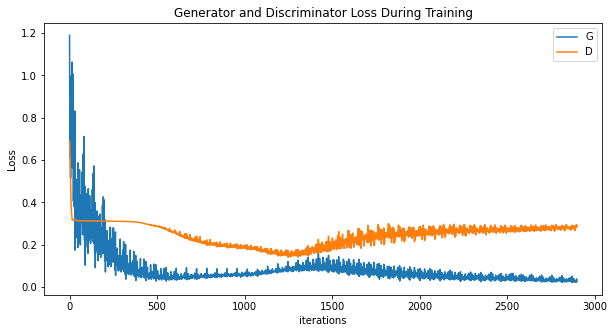

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gan_imputer.lossesG, label="G")
plt.plot(gan_imputer.lossesD, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### RMSE versus Epoch

Below is a plot of the RMSE during training and comparaison with mean imputation RMSE

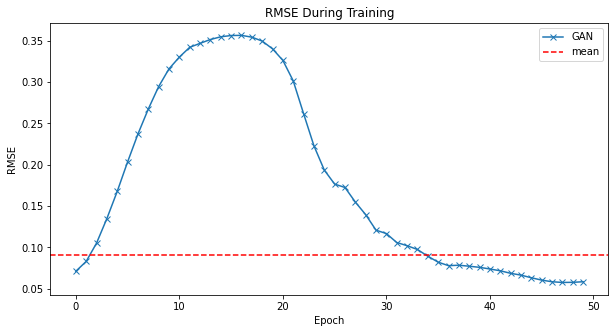

Minimum RMSE of 0.0576 achieved around epoch 48


In [7]:
# Compute the RMSE of mean imputation
mean_imputed = mean_impute(ucihar_miss.data)
mask = ~torch.isnan(ucihar_miss.data)
mean_rmse = imputation_rmse(ucihar_observed.data.numpy(), mean_imputed.numpy(), mask.numpy())

# Plot result
plt.figure(figsize=(10,5))
plt.title("RMSE During Training")
plt.plot(np.arange(num_epochs), gan_imputer.rmse_vals, marker='x', label="GAN")
plt.axhline(y=mean_rmse, color='r', linestyle='--', label="mean")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.savefig(f"rmse.png")
plt.show()

from operator import itemgetter
argmin_rmse, min_rmse = min(enumerate(gan_imputer.rmse_vals), key=itemgetter(1))
print(
    f"Minimum RMSE of {min_rmse:.4f} "
    f"achieved around epoch {(argmin_rmse + 1)}"
)


### Imputation

We now impute the data and save it in `x_imputed`.

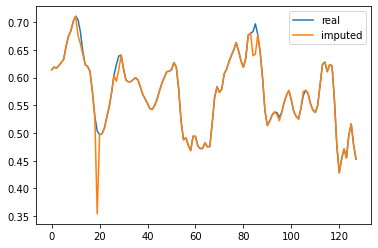

In [8]:
gan_imputed = gan_imputer.impute(x_miss=ucihar_miss.data)

# Plot some signal before/after imputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
plt.plot(ucihar_observed.data[sample_id, :, signal_id], label="real")
plt.plot(gan_imputed[sample_id, :, signal_id], label="imputed")
plt.legend()
plt.show()

###  Baringhaus Distance

For the statistical test between the distribution of the original and imputed data, we use the baringhaus distance.

In [9]:
# preprocess (remove overlap and reshape)
mask = ~torch.isnan(ucihar_miss.data)
original_data = preprocess_baringhaus(ucihar_observed.data, mask)
gan_imputed_data = preprocess_baringhaus(gan_imputed, mask)
mean_imputed_data = preprocess_baringhaus(mean_imputed, mask)

# compute baringhaus
gan_baringhaus = compute_stat_Baringhaus(original_data, gan_imputed_data)
mean_baringhaus = compute_stat_Baringhaus(original_data, mean_imputed_data)

print(f"Mean Baringhaus: {mean_baringhaus:.4f}")
print(f"GAN Baringhaus: {gan_baringhaus:.4f}")

Mean Baringhaus: 0.0035
GAN Baringhaus: 0.0013


### Performance Comparison for Classification Task

We compare the test accuracy obtained by training a classifier on the complete
dataset, mean imputation and our GAN-based imputation.

For the classifier, we use a simple GRU followed by a fully connected layer

#### Training the classifier on the GAN-imputed dataset

First, we train the classifier on the data imputed with GAN `gan_imputed`

In [7]:
# Classifier model
clf = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)


# Create loader for imputed data
dataloader_imp = DataLoader(
    TensorDataset(gan_imputed, ucihar_observed.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader_imp,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

Epoch [0/100]	 Loss: 1.570268	 Train Accuracy: 0.2972	Test Accuracy: 0.3359
Epoch [1/100]	 Loss: 1.574000	 Train Accuracy: 0.3651	Test Accuracy: 0.1805
Epoch [2/100]	 Loss: 1.428693	 Train Accuracy: 0.3685	Test Accuracy: 0.3397
Epoch [3/100]	 Loss: 1.271450	 Train Accuracy: 0.4314	Test Accuracy: 0.3977
Epoch [4/100]	 Loss: 1.086282	 Train Accuracy: 0.5447	Test Accuracy: 0.6284
Epoch [5/100]	 Loss: 0.948495	 Train Accuracy: 0.5866	Test Accuracy: 0.6776
Epoch [6/100]	 Loss: 0.720165	 Train Accuracy: 0.7070	Test Accuracy: 0.6946
Epoch [7/100]	 Loss: 0.626478	 Train Accuracy: 0.7380	Test Accuracy: 0.7350
Epoch [8/100]	 Loss: 0.585509	 Train Accuracy: 0.7380	Test Accuracy: 0.7503
Epoch [9/100]	 Loss: 0.590336	 Train Accuracy: 0.7440	Test Accuracy: 0.7706
Epoch [10/100]	 Loss: 0.516580	 Train Accuracy: 0.7682	Test Accuracy: 0.7584
Epoch [11/100]	 Loss: 0.499176	 Train Accuracy: 0.7741	Test Accuracy: 0.7696
Epoch [12/100]	 Loss: 0.492877	 Train Accuracy: 0.7858	Test Accuracy: 0.8090
Epoch [13

#### Training the classifier on the original dataset 


In [11]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

KeyboardInterrupt: 

#### Training the classifier on a mean-imputed dataset

Finally, for the sake of comparaison we also train the classifier on the dataset that is imputed using the **mean** method.

In [5]:
# Classifier model
clf = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)

# Create loader for imputed data
dataloader_mean = DataLoader(
    TensorDataset(mean_imputed, ucihar_observed.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train classifier
best_score = classify(
    model=clf,
    optimizer=optimizer,
    train_loader=dataloader_mean,
    test_loader=dataloader_test,
    num_epochs=clf_epochs,
    metric='Accuracy',
)
print(f"Best Accuracy obtained: {best_score:.4f}")

Epoch [0/100]	 Loss: 1.791329	 Train Accuracy: 0.2291	Test Accuracy: 0.1849
Epoch [1/100]	 Loss: 1.468748	 Train Accuracy: 0.3445	Test Accuracy: 0.3800
Epoch [2/100]	 Loss: 1.502568	 Train Accuracy: 0.3611	Test Accuracy: 0.4293
Epoch [3/100]	 Loss: 1.314536	 Train Accuracy: 0.4154	Test Accuracy: 0.3862
Epoch [4/100]	 Loss: 1.296811	 Train Accuracy: 0.4403	Test Accuracy: 0.5619
Epoch [5/100]	 Loss: 1.040586	 Train Accuracy: 0.5975	Test Accuracy: 0.6878
Epoch [6/100]	 Loss: 0.809782	 Train Accuracy: 0.6521	Test Accuracy: 0.6909
Epoch [7/100]	 Loss: 0.684746	 Train Accuracy: 0.7237	Test Accuracy: 0.7455
Epoch [8/100]	 Loss: 0.623045	 Train Accuracy: 0.7281	Test Accuracy: 0.7448
Epoch [9/100]	 Loss: 0.567803	 Train Accuracy: 0.7364	Test Accuracy: 0.7492
Epoch [10/100]	 Loss: 0.550016	 Train Accuracy: 0.7527	Test Accuracy: 0.7075
Epoch [11/100]	 Loss: 0.502639	 Train Accuracy: 0.7882	Test Accuracy: 0.7743
Epoch [12/100]	 Loss: 0.536138	 Train Accuracy: 0.7658	Test Accuracy: 0.7927
Epoch [13